### Import the libraries

In [1]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import copy
import random
import cv2
from tqdm import tqdm

d:\programming\transformer\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

# Read json file
with open('val.json', 'r') as f:
    data = json.load(f)

In [3]:
root = 'd:\\programming\\unet-livecell-project'
image_dir = r'D:\programming\unet-livecell-project\test_image\train_images'

### Process the masks based on .json file

In [4]:
# Get name of each image
image_name_list = []
files = os.listdir(image_dir)
for file in files:
    name, extension = os.path.splitext(file)
    if extension == '.tif':
        image_name_list.append(name)

In [5]:
image_id_to_segmentation = {}

# Collecting segmentation for each image_id
for image in data['images']:
    name, extension = os.path.splitext(image["file_name"])
    if name in image_name_list:
        image_id = image['id']
        segmentation_list = []
        for ann in data['annotations']:
            if ann['image_id'] == image_id:
                # Create a list of segmentation for each image, each list have corresponding (x, y) coordinate
                segmentation_list += ann['segmentation']
        image_id_to_segmentation[image_id] = {}
        image_id_to_segmentation[image_id]['segmentation'] = segmentation_list
        image_id_to_segmentation[image_id]['name'] = name

In [6]:
shape = (521, 705, 3)
# Create a mask for corresponding image id
for image_id in image_id_to_segmentation.keys():
    combined_mask = np.zeros(shape, dtype=np.float32)
    segmentation_list = image_id_to_segmentation[image_id]['segmentation']
    for segmentation in segmentation_list:
        mask = np.zeros(shape, dtype=np.bool8)
        rr, cc = polygon(segmentation[1::2], segmentation[0::2])
        mask[rr, cc] = 1
        # combined_mask += mask
        combined_mask = np.maximum(mask, combined_mask)
    name = image_id_to_segmentation[image_id]['name']
    plt.imshow(combined_mask, cmap='gray')
    # Save mask as gray scale image
    plt.imsave(rf'test_image/train_masks/{name}.png', combined_mask, cmap='gray')
    img_pil = Image.open(rf'test_image/train_masks/{name}.png')
    img_pil = img_pil.convert('L')
    img_pil.save(os.path.join(root, rf'test_image/train_masks/{name}.png'))

In [7]:
# Transform all the images to gray scale images
def transform_image(folder, save_folder, json_file):
    file_name_list = []
    for image in json_file['images']:
        file_name = image["file_name"]
        name, extension = os.path.splitext(file_name)
        file_name_list.append(name)
    for image in os.listdir(folder):
        name, extension = os.path.splitext(image)
        if name in file_name_list:
            img_path = os.path.join(folder, image)
            image = Image.open(img_path)
            image = image.convert('L')
            image.save(f'{save_folder}/{name}.png')

In [22]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Function using for elastic tranformation the dataset."""
    if random_state is None:
        random_state = np.random.RandomState()

    shape_size = image.shape[:2]

    # Downscaling the random grid and then upsizing post filter
    # improves performance. Approx 3x for scale of 4, diminishing returns after.
    grid_scale = 4
    alpha //= grid_scale  # Does scaling these make sense? seems to provide
    sigma //= grid_scale  # more similar end result when scaling grid used.
    grid_shape = (shape_size[0]//grid_scale, shape_size[1]//grid_scale)

    blur_size = int(4 * sigma) | 1
    rand_x = cv2.GaussianBlur(
        (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    rand_y = cv2.GaussianBlur(
        (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    if grid_scale > 1:
        rand_x = cv2.resize(rand_x, shape_size[::-1])
        rand_y = cv2.resize(rand_y, shape_size[::-1])

    grid_x, grid_y = np.meshgrid(np.arange(shape_size[1]), np.arange(shape_size[0]))
    grid_x = (grid_x + rand_x).astype(np.float32)
    grid_y = (grid_y + rand_y).astype(np.float32)

    distorted_img = cv2.remap(image, grid_x, grid_y,
        borderMode=cv2.BORDER_REFLECT_101, interpolation=cv2.INTER_LINEAR)

    return distorted_img

### Defining the model

In [23]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


### Defining the dataset

In [24]:
class Dataset():
    """Load and transform the dataset. The train dataset will have 2 parts: normal and augmented, therefore the size will be doubled"""
    def __init__(self, image_dir, mask_dir, transform=None, train = False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.train = train
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if self.train is True:
            img_path = os.path.join(self.image_dir, self.images[index])
            mask_path = os.path.join(self.mask_dir, self.images[index])

            angle = random.randint(0, 180)
            
            image = Image.open(img_path)
            # Rotate the image
            image = image.rotate(angle)
            # Convert the image to RGB image and crop
            image = np.array(image.convert('RGB'))
            image = image[:333, :434, :]                
            
            mask = Image.open(mask_path)
            # Rotate the mask with the same angle
            mask = mask.rotate(angle)
            # Convert the mask to binary image and crop
            mask = np.array(mask.convert('L'))
            mask = mask[:333, :434]
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask) 
                
                image = torch.tensor(image)
                mask = torch.tensor(mask)
                
                image = image.permute(1, 2, 0).numpy()
                mask = mask.squeeze(0).numpy()
                    
                # Apply elastic transformation with the fix seed for both image and mask
                random_state = np.random.RandomState(50)
                image = elastic_transform(image, mask.shape[1] * 2, mask.shape[1] * 0.08, random_state)
                mask = elastic_transform(mask, mask.shape[1] * 2, mask.shape[1] * 0.08, random_state)
                
                image = torch.tensor(image).permute(2, 0, 1)
                mask = torch.tensor(mask).unsqueeze(0)
                    
        # Normal transform for validation and test dataset        
        else:
            img_path = os.path.join(self.image_dir, self.images[index])
            mask_path = os.path.join(self.mask_dir, self.images[index])
            
            # Convert the image to RGB image and crop
            image = Image.open(img_path)
            image = np.array(image.convert('RGB'))
            image = image[:333, :434, :]  
            
            # Convert the mask to binary image and crop
            mask = Image.open(mask_path)
            mask = np.array(mask.convert('L'))
            mask = mask[:333, :434]
            
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
        
        return image, mask

In [25]:

TRAIN_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\train_images"
TRAIN_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\train_masks"
VAL_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\val_images"
VAL_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\val_masks"
TEST_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\test_images"
TEST_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\test_masks"

IMAGE_HEIGHT = 333  # 293 originally
IMAGE_WIDTH = 434 # 392 originally
EPOCHS = 30
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNET()
model.to(DEVICE)

# Normal transformation 
transform = torchvision.transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.ToTensor(),      
    ],
)

train_ds = Dataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform= transform, train=True)
val_ds = Dataset(image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR, transform= transform)
test_ds = Dataset(image_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, transform=transform)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=True)

loss_fn = DiceLoss(sigmoid=True,squared_pred=True)
# loss_fn = nn.BCELoss() #RuntimeError: Unable to find a valid cuDNN algorithm to run convolution
# loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceCELoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5, amsgrad=True)

### Sample images of the training data

C:\Users\PC\AppData\Local\Temp\ipykernel_4596\3127404703.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)
C:\Users\PC\AppData\Local\Temp\ipykernel_4596\3127404703.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask)


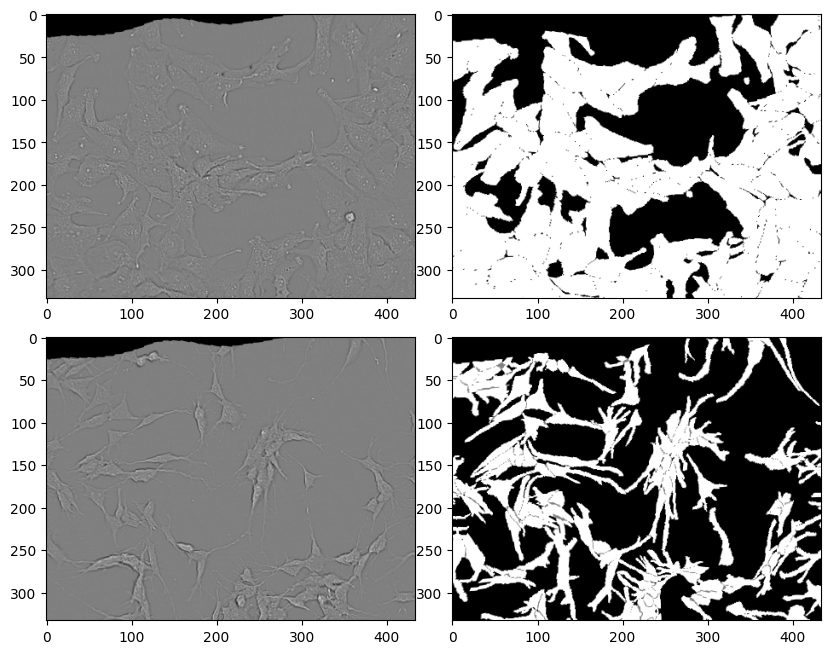

In [26]:
import matplotlib.gridspec as gridspec

(images, masks) = next(iter(train_loader))

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.1)

ax = plt.subplot(gs[0, 0])
ax.imshow(images[0].permute(1, 2, 0), cmap='gray')
ax = plt.subplot(gs[0, 1])
ax.imshow(masks[0].permute(1, 2, 0), cmap='gray')

ax = plt.subplot(gs[1, 0])
ax.imshow(images[1].permute(1, 2, 0), cmap='gray')
ax = plt.subplot(gs[1, 1])
ax.imshow(masks[1].permute(1, 2, 0), cmap='gray')

# show the plot
plt.show()


In [13]:
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in data:
        # batch_label = batch["seg"] != 0
        batch = batch != 0
        _, count = np.unique(batch, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count
    return val

In [14]:
def dice_weights(val1, val2):
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count / summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights / summ
    return torch.tensor(weights, dtype=torch.float32)

### Training

In [ ]:
train_loss_list = []
val_loss_list = []
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
smallest_loss = 1.0


for epoch in range(EPOCHS):
    # Train
    train_epoch_loss = 0.0
    for idx, (image, mask) in enumerate(train_loader):
        
        # pixels = calculate_pixels(mask)
        # weight = dice_weights(pixels[0][0], pixels[0][1])
        # loss_fn = DiceCELoss(sigmoid=True, ce_weight=torch.tensor([weight[0]]).to(DEVICE))
        
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        
        prediction = model(image)
        loss = loss_fn(prediction, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    epoch_loss = train_epoch_loss/len(train_loader)
    print("Epoch [{}/{}], Step [{}/{}], train_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(train_loader), epoch_loss))
    train_loss_list.append(epoch_loss)
    # Val
    with torch.no_grad():
        val_loss = 0.0
        for idx, (image, mask) in enumerate(val_loader):
            image = image.to(device=DEVICE)
            mask = mask.to(device=DEVICE)
            prediction = model(image)
            
            loss = loss_fn(prediction, mask)
            val_loss += loss.item()
        epoch_loss = val_loss/len(val_loader)
        print("Epoch [{}/{}], Step [{}/{}], val_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(val_loader), epoch_loss))
        if epoch_loss < smallest_loss:
            smallest_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        val_loss_list.append(epoch_loss)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
print('Smallest val loss: {:4f}'.format(smallest_loss))

In [ ]:
# Save model with the least loss
torch.save(best_model_wts, 'model/model_augmented_bceloss.pth')


In [14]:
performance = {}
performance["train_loss"] = train_loss_list
performance["val_loss"] = val_loss_list
with open('performance_model_new_augmented_bceloss.txt', 'w') as f:
    f.write(str(performance))

### Evaluation

In [18]:
model = UNET()
state_dict = torch.load('model/BEST_model_augmented_diceloss.pth')
model.load_state_dict(state_dict)
model.to(device=DEVICE)


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [19]:
# Calculate the total loss on the test dataset
model.eval()
with torch.no_grad():
    val_loss = 0.0
    total_loss = 0.0
    for idx, (image, mask) in enumerate(test_loader):
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        prediction = model(image)
        
        loss = loss_fn(prediction, mask)
        val_loss += loss.item()
    total_loss = val_loss/len(test_loader)
print(total_loss)

0.08176862121259094


tensor(0.3784, device='cuda:0')


Text(0.5, 1.0, 'ground truth')

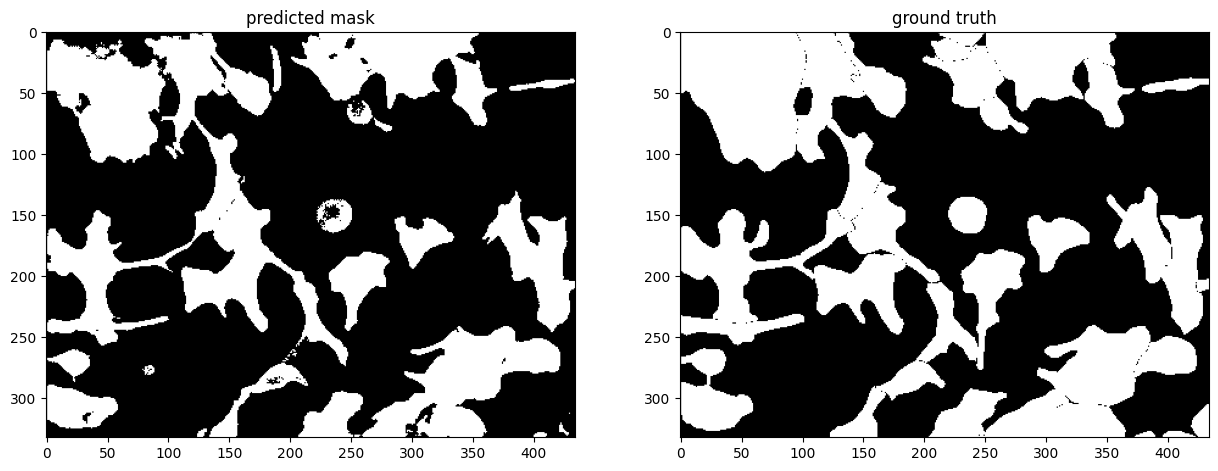

In [21]:
# Display some samples of ground true and prediction of the test dataset
model.eval()
input, mask = next(iter(test_loader))
image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
print(loss_fn(preds, mask[1].unsqueeze(0)))
preds = preds.cpu()
preds = preds.squeeze(0).squeeze(0)
mask = mask[1].squeeze(0).cpu()
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(preds, cmap='gray')
ax[0].set_title('predicted mask')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('ground truth')
